In [344]:
using CUDA, Flux, JLD2, Random, Statistics, LinearAlgebra, FFTW, ProgressMeter, Dates
using Flux: @epochs, train!, throttle, Zygote

In [345]:
using Plots

In [346]:
#if not nothing, train from a simpler model; if nothing, train from tabula rasa
pretrain_prefix = "0809_0958-0505_1536" #"0709_0956-0705_0839"#"0709_0956-0605_1727"

"0809_0958-0505_1536"

In [347]:
train = true
retrain = false
cubic = true #true if the measured pulses have a cubic phase
chirp = true #true if the measured pulses have a chirp
augment = true #true if the data is to be augmented
ssh = false
corr_pars = !ssh #if true, the first parameter resolved by NN is the true band gap; if false, t[0]
logamp = true #if true, logarithmic amplitudes are used; if false, absolute
learn_pars = true #false if the network doesn't have to resolve the crystal bands

true

In [458]:
#"0809_0958": unchirped
#"0709_0956": chirped
#"1209_1232": chirped with cubic phase
#"2605_1021": 50 mrad phase noise
#"2605_1457": 200 mrad phase noise

prefix = "0809_0958"

"0809_0958"

In [349]:
function cep_err(model, test_data)
    if size(test_data[2], 1) > 1
        cep_eval = test_data[2][1:2, :] |> cpu
    else
        cep_eval = vcat(cos.(test_data[2]), sin.(test_data[2])) |> cpu
    end
    cep_infd = (test_data[1] |> model |> cpu)[1:2, :]

    nrms = mapslices(norm, cep_infd, dims=1)
    cep_infd .= cep_infd./nrms

    cθ = diag(cep_eval'cep_infd)
    δφ = sqrt(2*mean(1.0 .- cθ))
    return δφ
end

cep_err (generic function with 1 method)

In [350]:
function disp_cep_err(model, test_data; show_full = false)
    println("CEP error:")
    println(round(cep_err(model, test_data), sigdigits=3))

    if (cubic || chirp) && show_full
        pulse_eval = test_data[2][3:end, :] |> cpu
        pulse_infd = (test_data[1] |> model |> cpu)[3:end, :]

        Δ = pulse_eval .- pulse_infd

        println("Absolute pulse parameter errors:")
        println(round.(vec(std(Δ, dims=2)), sigdigits=3))
        println("")
    end
    return nothing
end

disp_cep_err (generic function with 1 method)

In [354]:
function rev_norm(x; minmax = nothing) 
    if minmax == nothing
        return x
    else
        pars_min, pars_max = minmax
        return x.*(pars_max .- pars_min) .+ pars_min
    end
end

rev_norm (generic function with 1 method)

In [355]:
function disp_par_err(model, test_data; minmax = nothing)
    pars_eval = rev_norm(test_data[2] |> cpu, minmax=minmax)
    pars_infd = rev_norm(test_data[1] |> model |> cpu, minmax=minmax)
        

    Δ = pars_eval .- pars_infd
    Δ_rel = (pars_infd .- pars_eval)./pars_eval

    println("Absolute parameter errors:")
    println(round.(vec(std(Δ, dims=2)), sigdigits=3))
    println("")

    println("Relative parameter errors:")
    println(round.(vec(std(Δ_rel, dims=2)), sigdigits=3))
    println("")
    return nothing
end

disp_par_err (generic function with 1 method)

In [356]:
function train_NN!(N, model, loader, test_data, L; showbar=true, doplot=false, debug=false)
    loss_best = L(test_data...)
    pars_best = copy(collect(params(model)))

    showbar && (prog = Progress(N))
    doplot && (loss_test = zeros(N); loss = zeros(N))

    for i=1:N
        for d in loader
            ps = params(model)
            gs = Zygote.gradient(()->L(d...), ps)
            Flux.Optimise.update!(opt, ps, gs)
        end
        
        loss_curr, loss_train = Zygote.ignore() do
            L(test_data...; training=false), mean([L(d...; training=false) for d in loader])
        end
        
        showbar && next!(prog, showvalues=[(:epoch, i), (:loss, loss_train), (:loss_test, loss_curr)])
        
        loss_test[i] = loss_curr
        loss[i] = loss_train
        
        if loss_best > loss_curr
            loss_best = loss_curr
            pars_best = copy(collect(params(model)))
        end
    end
    
    if doplot
        return pars_best, (loss, loss_test)
    else 
        return pars_best
    end
end

train_NN! (generic function with 1 method)

In [357]:
function split(x::AbstractArray{T, 2} where T, ind::Int)
    return x[:,1:ind], x[:,ind+1:end]
end

function split(x::AbstractArray{T, 3} where T, ind::Int)
    return x[:,:,1:ind], x[:,:,ind+1:end]
end

split (generic function with 2 methods)

In [361]:
function circpad(x::AbstractArray{T, 3} where T, k::NTuple{1, Int})
    k1 = k[1]

    x_low = x[1:k1, :, :]
    x_high = x[end-k1+1:end, :, :]

    x = cat(x_high, x, x_low, dims=1)

    return x
end

circpad (generic function with 2 methods)

In [362]:
function circpad(x::AbstractArray{T, 4} where T, k::NTuple{2, Int})
    k1, k2 = k

    x_low = x[1:k1, :, :, :]
    x_high = x[end-k1+1:end, :, :, :]

    x = cat(x_high, x, x_low, dims=1)

    x_right = x[:,1:k2,:,:]
    x_left = x[:,end-k2+1:end,:,:]

    x = cat(x_left, x, x_right, dims=2)
    return x
end

circpad (generic function with 2 methods)

In [363]:
struct CircPad{N}
    k::NTuple{N,Int}
end

function (c::CircPad)(x) where T
    return circpad(x, c.k)
end

In [364]:
function disassemble(model::Chain, seq=[])
    for layer=model
        if layer isa Chain
            seq = disassemble(layer, seq)
        else
            append!(seq, [layer])
        end
    end
    return seq
end

disassemble (generic function with 2 methods)

In [366]:
function load_models(filename; band_key="M1", pulse_key="M2")
    file = jldopen(filename)
    band_model = file[band_key] |> copy
    pulse_model = file[pulse_key] |> copy

    M_pars = file["par_model"] |> gpu
    M_cep = file["cep_model"] |> gpu
    
    Flux.loadparams!(M_pars, band_model)
    Flux.loadparams!(M_cep, pulse_model)

    return M_pars, M_cep
end

load_models (generic function with 1 method)

In [367]:
function unnest(model, out_dim::Int=0)
    seq = disassemble(model)

    if out_dim != 0
        av_dim = size(seq[end].W, 1)
        @assert seq[end] isa Dense
        dim = min(av_dim, out_dim)
        rep = Dense(size(seq[end].W, 2), out_dim) |> gpu
        rep.W[1:dim, :] .= seq[end].W[1:dim, :]
        rep.b[1:dim] .= seq[end].b[1:dim]
        seq[end] = rep
    end

    return Chain(seq...)
end

unnest (generic function with 2 methods)

In [368]:
L_pars(x, y; training=false) = Flux.mse(M_pars(x), y)

function L_pars_aug(x::AbstractArray{T, 4}, y::AbstractArray{T, 2}; training = true, model = M_pars) where T
    out = (training ? circshift(x, (0, rand(0:Nφ-1), 0, 0)) : x) |> model
    Flux.mse(out, y)
end

function L_pars_aug(x::AbstractArray{T, 3}, y::AbstractArray{T, 2}; training = true, model = M_pars) where T
    out = (training ? circshift(x, (rand(0:Nφ-1), 0, 0)) : x) |> model
    Flux.mse(out, y)
end

L_pars_aug (generic function with 2 methods)

In [369]:
L_cep(x, y) = Flux.mse(M_cep(x), y)

function L_cep_aug(x, y; training = true)
    if training
        j = rand(1:Nφ)
        x_aug = circshift(x, (0, j-1, 0, 0))
        φ = φ_aug[j]
        rm = Zygote.ignore() do
            rm = Matrix(I, size(y, 1), size(y, 1)) |> Array{Float64}
            rm[1:2, 1:2] .= [[cos(φ), -sin(φ)] [sin(φ), cos(φ)]]
            gpu(rm)
        end
        return Flux.mse(M_cep(x_aug), rm*y)
    else
        return Flux.mse(M_cep(x), y)
    end
end

L_cep_aug (generic function with 1 method)

In [419]:
if train
    file = jldopen("nn-cep-2h/resps-cep-$prefix.jld2")

    cep = permutedims(file["cep"])
    if chirp
        try
            global chp = permutedims(file["chirp"])
        catch
            global chirp = false
        end

        if sum(abs2, chp) ≈ 0
            chirp = false
        end
    end
    if cubic
        try
            global cbp = permutedims(file["cbp"])#).^(1//3)
        catch
            global cubic = false
        end

        if sum(abs2, cbp) ≈ 0
            cubic = false
        end
    end
end

In [426]:
if train
    data = file["data_freq"][:,1:2:end,:]
    Nω, Nφ, N_pars = size(data)
    
    ξ = 0.0 #multiplicative noise magnitude
    
    data .= data.*(1.0-ξ .+ 2ξ.*rand(eltype(data), size(data)))
    
    if logamp
        data .= log10.(data)
    end
    
    data = (data .- mean(data, dims=(1, 2)))./std(data, dims=(1, 2))
end;

In [427]:
if train
    pars = ssh ? permutedims(hcat(file["delta"], file["h1"], file["h2"])) : file["pars"] |> copy

    if N_pars < 2^17
        aug_step = 2
    else
        aug_step = 2
    end

    ord = size(pars)[1]

    if corr_pars
        κ = range(-π, stop=π, length=101)

        @showprogress for j=1:N_pars
            pars[1, j] += minimum([sum(pars[i,j]*cos((i-1)*κ) for i=2:ord) for κ=κ])
        end
    end
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:20


In [428]:
if train
    ratio = 0.01
    N_train = N_pars*(1-ratio) |> round |> Int

    data_trn, data_tst = split(data, N_train)
    #data_c_trn, data_c_tst = split(data_cor, N_train)
    pars_trn, pars_tst = split(pars, N_train)
    cep_trn, cep_tst = split(cep, N_train)
    if chirp
        chp_trn, chp_tst = split(chp, N_train)
    end
    if cubic
        cbp_trn, cbp_tst = split(cbp, N_train)
    end
    
    data_trn = Flux.unsqueeze(data_trn, 3)
    data_tst = Flux.unsqueeze(data_tst, 3)
end;

In [429]:
if train
    φ_aug = collect(range(0.0, stop=2π, length=Nφ+1))[1:end-1]
end;

In [430]:
if train
    data_y = pars_trn
    data_y_tst = pars_tst
    data_yφ = vcat(cos.(cep_trn), sin.(cep_trn), eval.([:chp_trn, :cbp_trn][BitArray([chirp, cubic])])...)#, pars_trn)
    data_yφ_tst = vcat(cos.(cep_tst), sin.(cep_tst), eval.([:chp_tst, :cbp_tst][BitArray([chirp, cubic])])...)#, pars_tst)
    
    Q = data_y |> gpu
    R = data_yφ |> gpu

    P = data_trn |> gpu
    P_c = permutedims(data_trn[:,:,1,:], (2, 1, 3)) |> gpu
    data_c_tst = permutedims(data_tst[:,:,1,:], (2, 1, 3)) |> gpu

    test_data_p = (gpu(data_tst), gpu(data_y_tst))
    test_data_cep = (gpu(data_tst), gpu(data_yφ_tst))
end;

In [377]:
conv_link_zp(k, n1, n2; zero_init=false, stride=1) = Chain(Conv((k, k), n1=>n2, pad=(k÷2, k÷2), 
        stride=stride, init=zero_init ? zeros : Flux.glorot_uniform), 
    BatchNorm(n2, swish)) |> gpu

conv_link_zp (generic function with 1 method)

In [378]:
conv_stack_zp(k, n1, n2, r) = Chain(conv_link_zp(k, n1, n2), [conv_link_zp(k, n2, n2; zero_init=true) for _=1:r-1]...)

conv_stack_zp (generic function with 1 method)

In [379]:
conv_link(k, n1, n2; zero_init=false, stride=1) = Chain(CircPad((0, k÷2)), 
    Conv((k, k), n1=>n2, pad=(k÷2, 0),
        stride=stride, init=zero_init ? zeros : Flux.glorot_uniform), 
    BatchNorm(n2, swish)) |> gpu

conv_link (generic function with 1 method)

In [380]:
function add_pad(x::AbstractArray{T, 4}, y::AbstractArray{T, 4}) where T
    (x, y) = size(x, 3) >= size(y, 3) ? (x, y) : (y, x) 
    
    return x + cat(y, gpu(zeros(size(y)[1:2]..., size(x, 3) - size(y, 3), size(x, 4))), dims = 3)
end

add_pad (generic function with 1 method)

In [381]:
function res_link(n_in, n_out=n_in)
    if n_out == n_in
        m = Chain(conv_link(3, n_in, n_out), 
            conv_link(3, n_out, n_out, zero_init=true)) |> gpu |> unnest
        return SkipConnection(m, +)
    else
        m = Chain(conv_link(3, n_in, n_out, stride=2), 
            conv_link(3, n_out, n_out, zero_init=true)) |> gpu |> unnest
        
        m_linc = Conv((1, 1), n_in=>n_out, bias=false, stride=2) #option B
        return Parallel(+, m, m_linc)
    end
end

res_link (generic function with 2 methods)

In [240]:
function add_noise(x::AbstractArray{T, N} where N, ξ::T; dist=:gaussian) where T
    if dist == :gaussian
        return x.*typeof(x)(one(T) .+ ξ.*randn(T, size(x)))
    elseif dist == :uniform
        return x.*typeof(x)(one(T)-ξ .+ 2ξ.*rand(T, size(x)))
    else
        throw(ErrorException)
    end
end

add_noise (generic function with 1 method)

In [382]:
conv_stack(k, n1, n2, r; mp_k=2, mp_stride=2) = Chain(conv_link(k, n1, n2), [conv_link(k, n2, n2) for _=1:r-1]..., MaxPool((mp_k, mp_k), stride=mp_stride))

conv_stack (generic function with 1 method)

In [383]:
cat3(args...) = cat(args..., dims=3)

cat3 (generic function with 1 method)

In [384]:
conv_link_dn(k, n1, n2; stride=1) = Chain(BatchNorm(n1, swish), 
    CircPad((0, k÷2)),
    Conv((k, k), n1=>n2, pad=(k÷2, 0), stride=stride)) |> gpu

conv_link_dn (generic function with 1 method)

In [385]:
#the original DenseNet paper states that a memory-optimal realization would have 2 caches, and anyone who tinkers with this code is encouraged to screw around and find out if that makes it better

struct DenseBlock
    blocks::Array{Any}
    k0::Int
    m::Int
    k::Int
end

function DenseBlock(k0, m, k=12)
    blocks = [Chain(conv_link_dn(1, k0+(i-1)*k, k), conv_link_dn(3, k, k)) |> gpu |> unnest for i=1:m]
    return DenseBlock(blocks, k0, m, k)
end

function (db::DenseBlock)(x)
    outs = Zygote.Buffer(x, size(x)[1:2]..., db.k0+db.m*db.k, size(x)[end])
    outs[:,:,1:db.k0,:] = x
    
    for (i, block) = enumerate(db.blocks)
        fst = db.k0 + (i-1)*db.k
        outs[:,:,fst + 1: fst + db.k,:] = outs[:,:,1:fst,:] |> copy |> block
    end
    
    return copy(outs)
end

In [387]:
TransBlock(k0; θ=0.5) = Chain(BatchNorm(k0, swish), Conv((1, 1), k0=>Int(round(k0*θ))), MeanPool((2, 2))) |> gpu

TransBlock (generic function with 1 method)

In [388]:
CUDA.allowscalar(false)

In [389]:
if train
    D2 = 1024
    D3 = 512

    dummy = randn(Nω, Nφ, 1, 1) |> gpu
    d_par = size(data_y, 1)
    d_cep = size(data_yφ, 1)
    
    @assert dummy isa CuArray #Flux sometimes works weirdly with IJulia
end;

In [390]:
empty!(Out)

Dict{Int64, Any} with 1 entry:
  390 => Dict{Int64, Any}(#= circular reference @-1 =#)

In [391]:
if train
    if isnothing(pretrain_prefix)
        M_cep_conv = Chain(conv_link(9, 1, 64),
            MaxPool((3, 3), stride=2),
            conv_link(7, 64, 128),
            MaxPool((2, 2)),
            conv_link(5, 128, 256),
            MaxPool((2, 2)),
            conv_link(3, 256, 512),
            MaxPool((2, 2)),
            flatten) |> gpu |> unnest
        M_cep_dense = Chain(Dense(size(M_cep_conv(dummy), 1), D3, swish), Dense(D3, d_cep)) |> gpu
        M_cep = Chain(M_cep_conv, M_cep_dense) |> unnest

        k_gr = 24
        ns = [1, k_gr]
        ks = [7]
        reps = [1]
        
        ch_res = [64, 128, 256, 512] #this can and will resemble ResNet18, save for minor details
        reps_res = [2, 2, 2, 2]
        
        reps_dn = [6, 12, 24, 16] #[6, 12, 24, 16] for DenseNet-121
        #[6, 12, 32, 32] for DenseNet-169
        #[6, 12, 48, 32] for DenseNet-201
        #[6, 12, 64, 48] for DenseNet-264
        
        ns_res = vcat(ns[end], [Iterators.repeated(ch_res[i], reps_res[i]) |> collect for i=eachindex(ch_res)]...)

        #=denseblocks = []
        d_run = k_gr
        θ = 0.5
        for i in 1:length(reps_dn)-1
            push!(denseblocks, DenseBlock(d_run, reps_dn[i], k_gr))
            d_run = d_run+k_gr*reps_dn[i]
            push!(denseblocks, TransBlock(d_run; θ=θ))
            d_run = Int(round(θ*d_run))
        end
        
        push!(denseblocks, DenseBlock(d_run, reps_dn[end], k_gr))=#
        
        M_pars_conv = Chain(conv_link(9, 1, 64),
            MaxPool((3, 3), stride=2),
            conv_link(7, 64, 128),
            MaxPool((2, 2)),
            conv_link(5, 128, 256),
            MaxPool((2, 2)),
            conv_link(3, 256, 512),
            MaxPool((2, 2)),
            flatten) |> gpu |> unnest
        
        M_pars_dense = Chain(Dense(size(M_pars_conv(dummy), 1), D3, swish), Dense(D3, d_par)) |> gpu
        M_pars = Chain(M_pars_conv, M_pars_dense) |> unnest
        preloaded = false
    else
        M_pars, M_cep = unnest.(load_models("trained-weights/results-$pretrain_prefix.jld2"))

        preloaded = true
    end
    
    dummy |> M_pars[1:end-3] |> size
end

(2, 1, 512, 1)

In [392]:
size.(test_data_p)

((41, 32, 1, 655), (4, 655))

In [431]:
if preloaded
    disp_par_err(M_pars, test_data_p)
    disp_cep_err(M_cep, test_data_cep)
end

Absolute parameter errors:
Float32[0.0241, 0.0301, 0.0367, 0.0252]

Relative parameter errors:
Float32[0.00442, 0.0123, 1.65, 5.34]

CEP error:
0.0179


In [51]:
if train && learn_pars
    N_epochs = preloaded ? 50 : 200
    train_loader_p = Flux.Data.DataLoader((P, Q), batchsize=256, shuffle=true)
    opt = Flux.Optimiser(Flux.ExpDecay(0.001, 0.1, Int(length(train_loader_p)*N_epochs*0.75)), AdaBelief())

    band_model, loss = train_NN!(N_epochs, M_pars, train_loader_p, test_data_p, L_pars_aug, doplot=true)
    disp_par_err(M_pars, test_data_p)

    Flux.loadparams!(M_pars, band_model)
    
    plot([loss[1], loss[2]], yscale=:log10, label=["train" "test"])
end

In [459]:
train && disp_par_err(M_pars, test_data_p)

Absolute parameter errors:
Float32[0.0241, 0.0301, 0.0367, 0.0252]

Relative parameter errors:
Float32[0.00442, 0.0123, 1.65, 5.34]



In [53]:
if train
    M_cep = unnest(M_cep, size(data_yφ, 1))
    
    N_epochs = preloaded ? 50 : 200
    opt = Flux.Optimiser(Flux.ExpDecay(0.001, 0.1, Int(length(train_loader_p)*N_epochs*0.75)), AdaBelief())
    
    train_loader_cep = Flux.Data.DataLoader((P, R), batchsize=256, shuffle=true)
    pulse_model, loss = train_NN!(N_epochs, M_cep, train_loader_cep, test_data_cep, L_cep_aug; doplot=true)
    disp_cep_err(M_cep, test_data_cep)

    Flux.loadparams!(M_cep, pulse_model)
    
    plot([loss[1], loss[2]], yscale=:log10, label=["train" "test"])
end

In [460]:
if train
    disp_cep_err(M_cep, test_data_cep)
end

CEP error:
0.0179


In [432]:
if train
    pulse_true = test_data_cep[2] |> cpu
    pulse_infd = test_data_cep[1] |> M_cep |> cpu

    pars_eval = test_data_p[2] |> cpu
    pars_infd = test_data_p[1] |> M_pars |> cpu

    mrk = Dates.format(now(), "ddmm_HHMM")

    jldopen("trained-weights/results-$prefix-$mrk.jld2", true, true, true, IOStream) do io
        write(io, "logamp", logamp)
        write(io, "data_tst", data_tst)
        write(io, "pars_true", pars_eval)
        write(io, "pars_infd", pars_infd)
        write(io, "pulse_true", pulse_true)
        write(io, "pulse_infd", pulse_infd)
        write(io, "M1", cpu(collect(band_model)))
        write(io, "M2", cpu(collect(pulse_model)))
        write(io, "cep_model", cpu(M_cep))
        write(io, "par_model", cpu(M_pars))
    end
else
    prefix= "0809_0958"
    mrk = "0505_1536"
    M_pars, M_cep = load_models("trained-weights/results-$prefix-$mrk.jld2")
end

The below cells run the transfer learning sequence

In [228]:
using HDF5

In [449]:
fid = h5open("data.random.h5", "r")

🗂️ HDF5.File: (read-only) data.random.h5
├─ 🔢 data
└─ 🔢 parameters

In [450]:
Nφ = size(fid["data"], 1)
Nω = size(fid["data"], 2)
N_trans = size(fid["data"], 3)

ind_c = 1:N_trans #.! (536 .<= (1:N_trans) .<= 540)

data_fid = fid["data"] |> Array |> x->reshape(x, Nφ, Nω, :) |> x->permutedims(x, (2, 1, 3))
pars_fid = fid["parameters"] |> Array |> x->reshape(x, size(fid["parameters"], 1), :)

fid_add = [h5open(filename, "r") for filename=[]] #"data.random.h5"

for f in fid_add
    data_f = f["data"] |> Array |> x->reshape(x, Nφ, Nω, :) |> x->permutedims(x, (2, 1, 3))
    global data_fid = cat(data_fid, data_f, dims=3)
    pars_f = f["parameters"] |> Array |> x->reshape(x, size(fid["parameters"], 1), :)
    global pars_fid = cat(pars_fid, pars_f, dims=2)
end

if logamp
    data_fid .= data_fid./2
else
    data_fid .= exp10.(data_fid./2)
end

data_fid = data_fid[:,:,ind_c]
pars_fid = pars_fid[:,ind_c]

data_fid = (data_fid .- mean(data_fid, dims=(1, 2)))./std(data_fid, dims=(1, 2));

In [451]:
ratio = 0.2
N_train = Int(round(N_trans*(1-ratio)))
N_test = N_trans - N_train

50

In [452]:
N_pars = size(data_fid, 3)
inds = randperm(N_pars)
data_fid = data_fid[:, :, inds]
pars_fid = pars_fid[:, inds];

In [453]:
pars_min = minimum(pars_fid[1:2, :], dims=2)
pars_max = maximum(pars_fid[1:2, :], dims=2)

data_trn, data_tst = split(data_fid, N_train)
pars_trn, pars_tst = split((pars_fid[1:2,:] .- pars_min)./(pars_max .- pars_min), N_train); #the parameters are normalized here

In [457]:
extrema(pars_fid, dims=2)

3×1 Matrix{Tuple{Float64, Float64}}:
 (4.0086, 7.2521)
 (0.08, 0.15943)
 (0.0, 6.248278722139699)

In [259]:
cep_trn, cep_tst = split(permutedims(pars_fid[3,:]), N_train);

In [260]:
φ_aug = collect(range(0.0, stop=2π, length=Nφ+1))[1:end-1];

In [261]:
data_y = pars_trn

data_yφ, data_yφ_tst = [vcat(cos.(cep), sin.(cep)) for cep=[cep_trn, cep_tst]] |> Tuple #
#data_yφ_tst = vcat(cos.(cep_tst), sin.(cep_tst))

Q = data_y |> gpu
R = data_yφ |> gpu

P = Flux.unsqueeze(data_trn, 3) |> gpu

test_data_p = (Flux.unsqueeze(gpu(data_tst), 3), gpu(pars_tst))

test_data_cep = (Flux.unsqueeze(gpu(data_tst), 3), gpu(data_yφ_tst));
train_loader_cep = Flux.Data.DataLoader((P, R), batchsize=512, shuffle=true, partial=false);

In [237]:
file_source = jldopen("trained-weights/results-$prefix-$mrk.jld2")

pulse_model = file_source["M2"] |> copy;

In [238]:
#M_pars, M_cep = load_models("trained-weights/results-transfer-0809_0958-0906_1426.jld2", band_key="M1t", pulse_key="M2t")

In [247]:
band_model = file_source["M1"];
M_pars = unnest(M_pars, 4)
Flux.loadparams!(M_pars, band_model)
M_pars = unnest(M_pars, size(pars_trn, 1));

In [241]:
using LaTeXStrings, Plots.PlotMeasures

The training data are not affected by multiplicative noise here. This doesn't seem to worsen the NN's performance on noisy data.

0.018391090701486826
[0.021143642033617103; 0.000534142101417639]


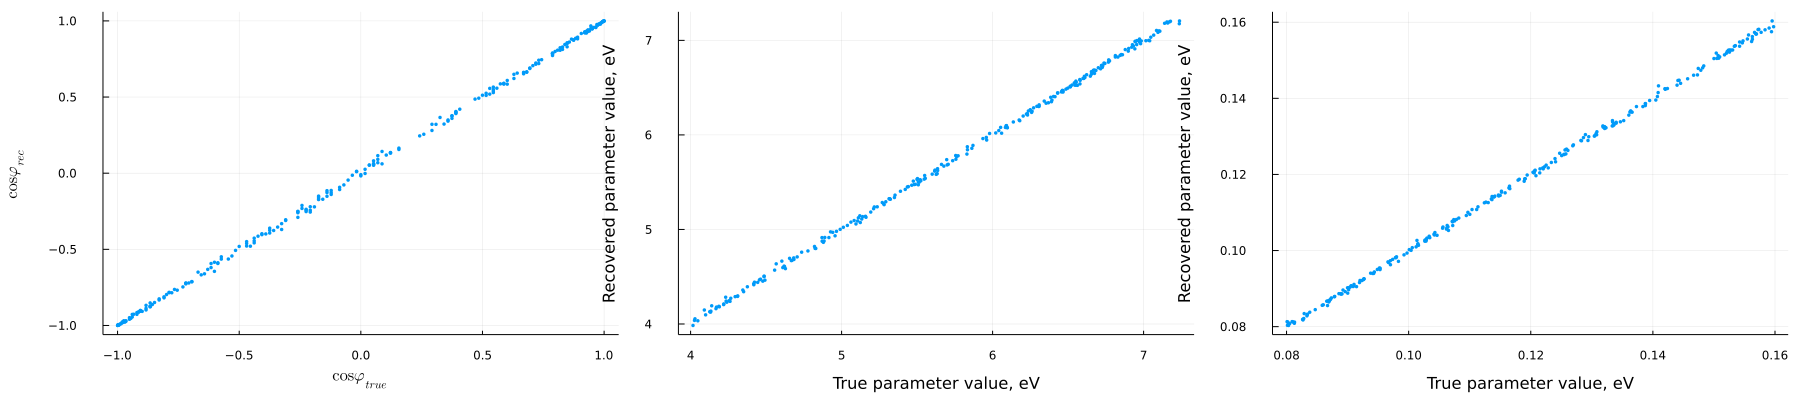

In [286]:
x_all = Flux.unsqueeze(data_fid, 3) |> gpu

ξ = 0.1f0
x_all .= log10.(add_noise(exp10.(x_all), ξ, dist=:uniform))

pars_all = pars_fid[1:2, :]
cep_all = pars_fid[3:3, :]
y_all = vcat(cos.(cep_all), sin.(cep_all)) |> gpu

let (x, cep)=(test_data_cep[1], cep_tst), (y, pars)=(test_data_p[1], pars_tst), ind=1
    z = M_cep(x)[1:2,:] |> cpu
    φ_rec = mapslices(rec_angle, z, dims=1) #atan.(z[2,:], z[1,:]) |> permutedims #
    φ_rec[φ_rec .< 0] .+= 2π
    
    pars_rec = rev_norm(M_pars(y) |> cpu, minmax=(pars_min, pars_max))
    pars_unorm = rev_norm(pars |> cpu, minmax=(pars_min, pars_max))
    
    println(sqrt.(2 .*(1 .- mean(cos.(cpu(cep) .- φ_rec)))))
    
    p1 = plot(cos.(cep) |> vec |> cpu, cos.(φ_rec) |> vec, seriestype=:scatter, 
        legend=false, markerstrokealpha=0.0, markerstrokewidth=0, 
        xlabel=L"\cos\varphi_{true}", ylabel=L"\cos\varphi_{rec}", markersize=2, left_margin=10mm, bottom_margin=10mm)
    
    println(std(pars_rec .- pars_unorm, dims=2))
    
    pp = [plot(pars_unorm[j,:] |> cpu, pars_rec[j,:] |> cpu, seriestype=:scatter, 
            legend=false, markerstrokealpha=0.0, markerstrokewidth=0, 
            xlabel="True parameter value, eV", ylabel="Recovered parameter value, eV", markersize=2) for j=1:2]
    
    plot(p1, pp..., layout=(1, 3), size=(1800, 400))
    
    #plot(sum(y.*z_norm, dims=1) |> vec |> cpu, err, marker_z=log10.(norms) |> vec |> cpu, seriestype=:scatter, legend=false, markerstrokewidth=0)
    #plot!([0.0], [cos(φ_aug[cs_j+1])], seriestype=:scatter, c=:red)
end

In [279]:
mrk = Dates.format(now(), "ddmm_HHMM")

savefig("output-$mrk.png")

In [251]:
disp_par_err(M_pars, test_data_p)

Absolute parameter errors:
Float32[0.349, 0.893]

Relative parameter errors:
Float32[80.0, 115.0]



In [266]:
M_cep = unnest(M_cep, 2);
Flux.loadparams!(M_cep, pulse_model)
M_cep = unnest(M_cep, size(data_yφ, 1));

In [68]:
println(L_cep_aug(test_data_cep...))
println(L_cep_aug(P, R))

0.3957275
0.39321405


In [267]:
N_epochs = 400
opt = Flux.Optimiser(Flux.ExpDecay(0.001, 0.1, length(train_loader_cep)*Int(N_epochs*0.75)), AdaBelief());

In [280]:
disp_cep_err(M_cep, test_data_cep)

CEP error:
0.0184


Even in spite of training the entire network rather than just the initial layers, the lines below do not result in an overfit. The error when training both the FC and the conv layers is about 0.019, and about 0.072 when you limit it to FC

In [270]:
pulse_model_trans, loss = train_NN!(N_epochs, M_cep, train_loader_cep, test_data_cep, L_cep_aug; doplot=true)
disp_cep_err(M_cep, test_data_cep)

┌ Warning: ProgressMeter by default refresh meters with additional information in IJulia via `IJulia.clear_output`, which clears all outputs in the cell. 
│  - To prevent this behaviour, do `ProgressMeter.ijulia_behavior(:append)`. 
│  - To disable this warning message, do `ProgressMeter.ijulia_behavior(:clear)`.
└ @ ProgressMeter /home/n.klimkin/.julia/packages/ProgressMeter/l7LEt/src/ProgressMeter.jl:593
Progress: 100%|█████████████████████████████████████████| Time: 0:03:21
  epoch:      400
  loss:       0.00016885783
  loss_test:  0.00019793573


CEP error:
0.0184


In [272]:
train_loader_p = Flux.Data.DataLoader((P, Q), batchsize=512, shuffle=true);

In [273]:
N_epochs = 2000
opt = Flux.Optimiser(Flux.ExpDecay(0.001, 0.1, length(train_loader_p)*Int(N_epochs*0.95)), AdaBelief());

In [274]:
band_model_trans, loss = train_NN!(N_epochs, M_pars, train_loader_p, test_data_p, L_pars_aug; doplot=true)
disp_par_err(M_pars, test_data_p; minmax=(pars_min, pars_max))

┌ Warning: ProgressMeter by default refresh meters with additional information in IJulia via `IJulia.clear_output`, which clears all outputs in the cell. 
│  - To prevent this behaviour, do `ProgressMeter.ijulia_behavior(:append)`. 
│  - To disable this warning message, do `ProgressMeter.ijulia_behavior(:clear)`.
└ @ ProgressMeter /home/n.klimkin/.julia/packages/ProgressMeter/l7LEt/src/ProgressMeter.jl:593
Progress: 100%|█████████████████████████████████████████| Time: 0:17:21
  epoch:      2000
  loss:       4.1298277e-5
  loss_test:  4.3213025e-5


Absolute parameter errors:
[0.0211, 0.000534]

Relative parameter errors:
[0.0039, 0.00455]



In [290]:
inp_noisy = log10.(add_noise(exp10.(test_data_cep[1]), 0.1f0))

pulse_true = test_data_cep[2] |> cpu
pulse_infd = inp_noisy |> M_cep |> cpu

pars_eval = rev_norm(test_data_p[2] |> cpu; minmax=(pars_min, pars_max))
pars_infd = rev_norm(inp_noisy |> M_pars |> cpu; minmax=(pars_min, pars_max));

In [291]:
mrk = Dates.format(now(), "ddmm_HHMM")

jldopen("trained-weights/results-transfer-$prefix-$mrk.jld2", true, true, true, IOStream) do io
    write(io, "logamp", logamp)
    write(io, "data_tst", data_tst)
    write(io, "cep_tst", cep_tst)
    write(io, "M1", cpu(collect(band_model)))
    write(io, "M2", cpu(collect(pulse_model)))
    write(io, "M1t", cpu(collect(band_model_trans)))
    write(io, "M2t", cpu(collect(pulse_model_trans)))
    write(io, "cep_model", cpu(M_cep))
    write(io, "par_model", cpu(M_pars))
    write(io, "pars_true", pars_eval)
    write(io, "pars_infd", pars_infd)
    write(io, "pulse_true", pulse_true)
    write(io, "pulse_infd", pulse_infd)
end

In [292]:
h5open("trained-weights/results-transfer-$prefix-$mrk.hdf5", "w") do io
    write(io, "pars_true", pars_eval)
    write(io, "pars_infd", pars_infd)
    write(io, "pulse_true", pulse_true)
    write(io, "pulse_infd", pulse_infd)
end